In [137]:
import pandas as pd
import numpy as np
import re
import time

import requests

import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
df = pd.read_csv('all_accident_data.csv', index_col=False)

In [73]:
# replaces Xs with *s in VIN for improved use with NTHSA cross reference
df.car_vin = df.car_vin.apply(lambda row: re.sub(r'(\w{4})X+(\d{4})', r'\1*********\2', row))

# creates column with shorthand vehicle damage
df['vehicle_damage_abbr'] = df.driver_car_damage.apply(lambda row: re.search(r'^(\S+){1,4}.+', row).group(1))

# replaces non numerical values and transforms dtype to int
df.car_year = df.car_year.apply(lambda row: re.sub(r'\s?(\d{4})(.0)?', r'\1', str(row)))
df.car_year = df.car_year.apply(lambda row: re.sub(r'(\s*[A-Z\sa-z]+\s*)', r'-1', str(row)))
df.car_year = df.car_year.astype('int')

# convert crash_date to datetime dtype and 24-hour clock
df.crash_date =  df.crash_date.apply(lambda row: pd.to_datetime(row).strftime('%d/%m/%Y %H:%M:%S'))

# set DL state as Texas, Other, or NaN
df.driver_license_state = np.where(df.driver_license_state.isin(['UNKNOWN', 'Unknown']), np.nan, df.driver_license_state)
df.driver_license_state = np.where(df.driver_license_state.isin(['Texas', np.nan]), df.driver_license_state, 'Other')

# drop columns
df = df.drop(columns=['Unnamed: 0', 'crash_city', 'police_dept', 'driver_residence', 'index'])

In [176]:
df.columns

Index(['crash_url', 'case_id', 'crash_id', 'crash_date', 'crash_latitude',
       'crash_longitude', 'accident_factor', 'speed_limit', 'crash_location',
       'num_of_injuries', 'num_of_vehicles', 'num_of_occupants', 'at_fault',
       'car_contained_injury', 'car_make', 'car_year', 'car_color', 'car_vin',
       'driver_age', 'driver_gender', 'driver_ethnicity', 'driver_car_damage',
       'driver_license_type', 'driver_license_state', 'driver_insured',
       'traffic_conditions', 'weather_conditions', 'vehicle_damage_abbr'],
      dtype='object')

<AxesSubplot:xlabel='crash_latitude', ylabel='crash_longitude'>

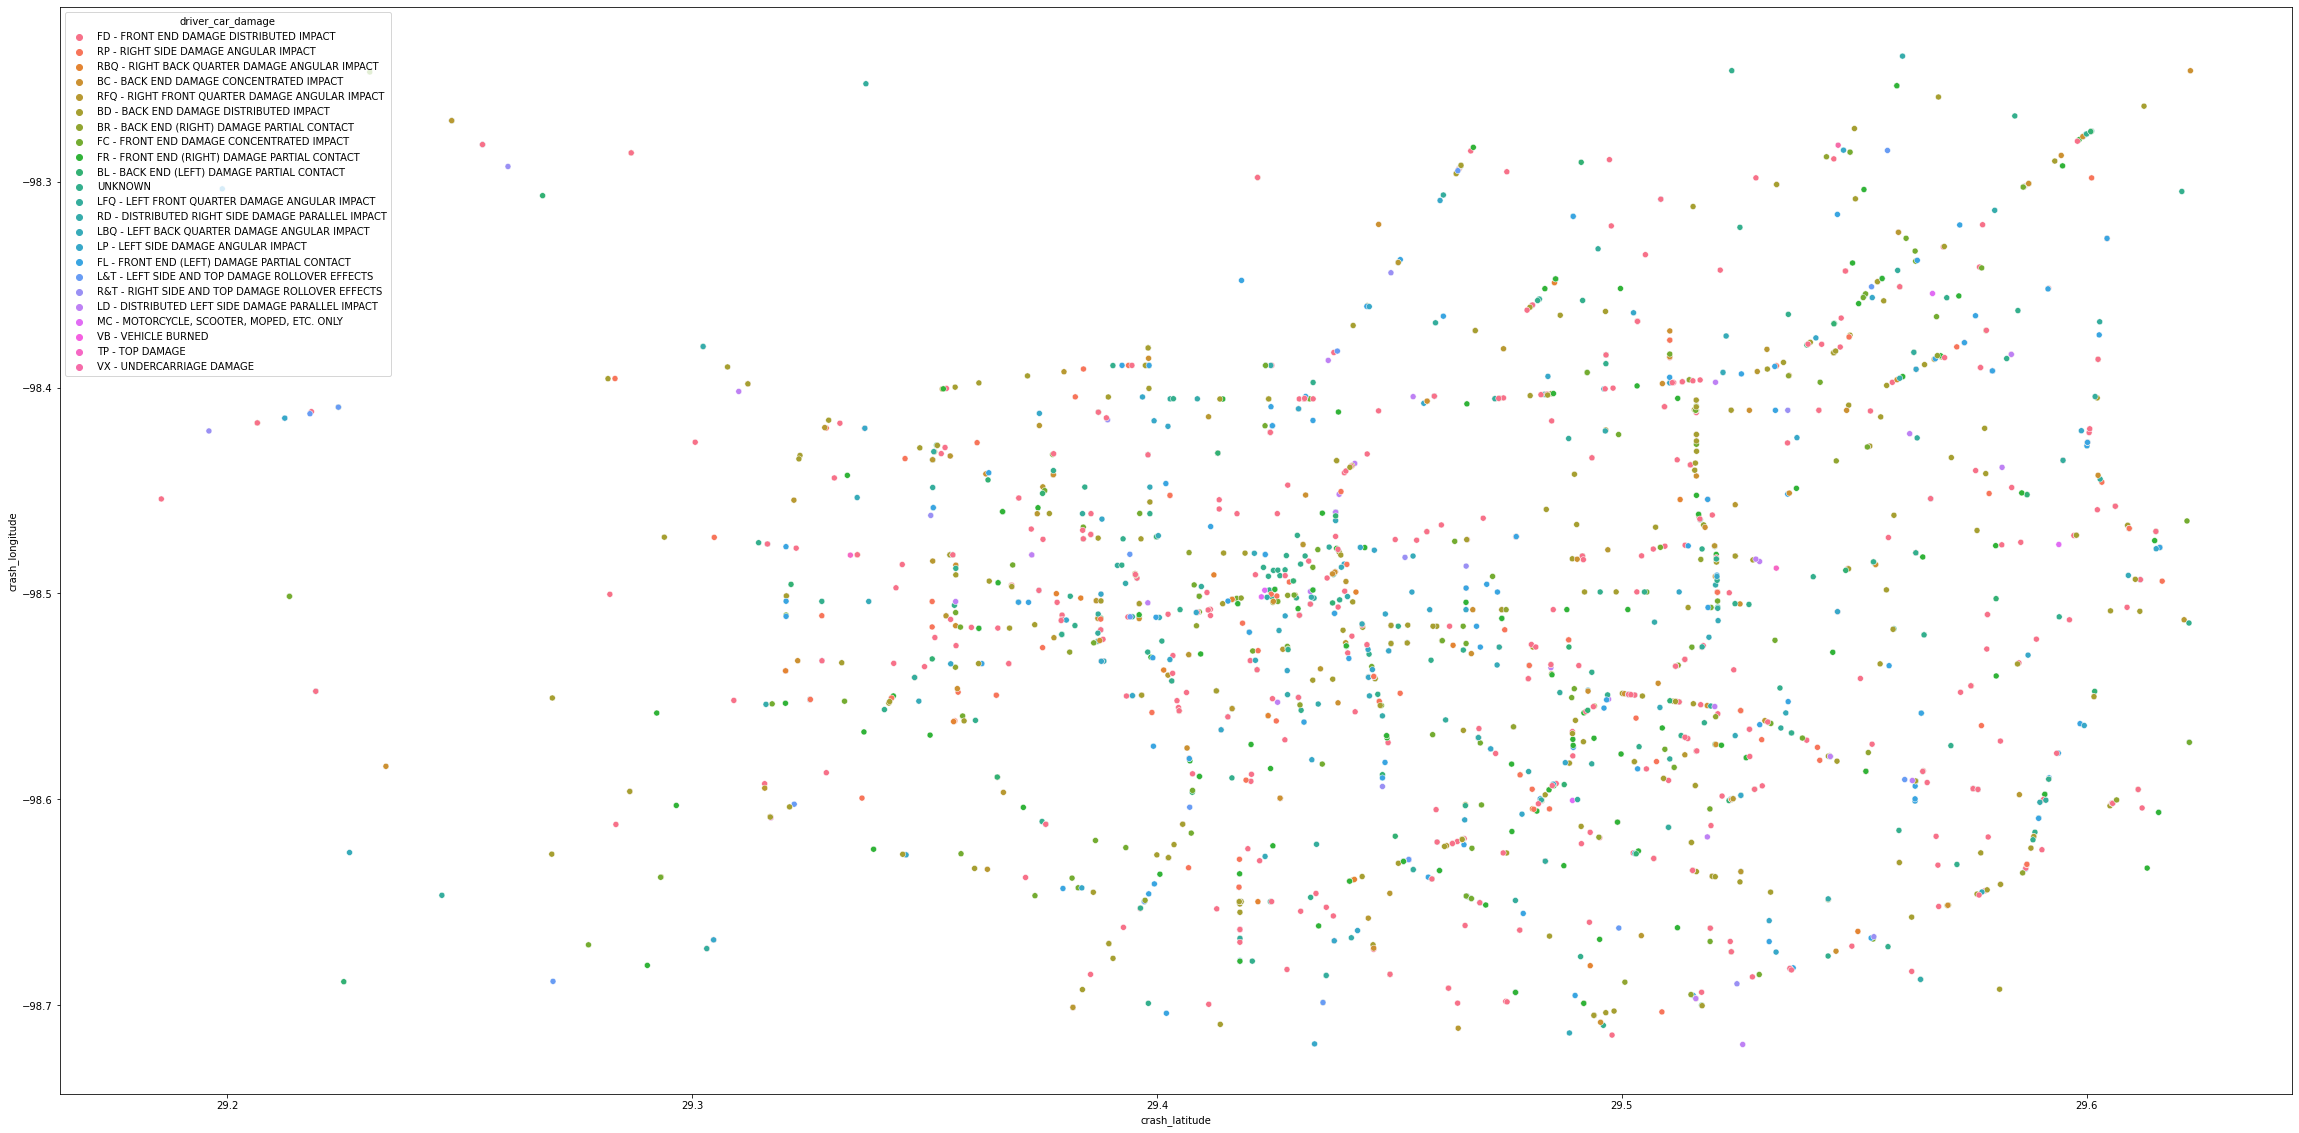

In [175]:
plt.figure(figsize=(40,20))
sns.scatterplot(data=df[((df.car_contained_injury == 1) & (df.num_of_occupants) ], x = 'crash_latitude', y = 'crash_longitude', hue='driver_car_damage')

In [158]:
def get_Vehicle_type(vin):
    url = 'https://vpic.nhtsa.dot.gov/api/vehicles/DecodeVINValuesBatch/';
    post_fields = {'format': 'json', 'data': vin};
    r = requests.post(url, data=post_fields);
    VehicleType = r.json()['Results'][0]['VehicleType']
    return VehicleType

In [145]:
#
#df['car_type'] = df['car_vin'].apply(get_Vehicle_type)